# **Entrenamiento red neuronal**
***



En este código se entrenará a la red neuronal con las imagenes previamente recortadas.

<a id="1"></a>
## 1. Carga de datos

Importación de librerías

In [ ]:
from google.colab import drive
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
import os
from functools import reduce
from datetime import datetime
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error


Definir hiperparámetros.

In [ ]:
epochs = 20
batch_size = 64
num_classes = 100
margin = 1
exec_time = datetime.today().strftime('%Y-%m-%d %Hh %Mm')

Carga red neuronal resnset 50

In [ ]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Carga de las imagenes, a través del directorio

In [ ]:
img_dir = "/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/"
img_size = (178,218)

<a id="2"></a>
## 2. Definición de  funciones

En este apartado se definer las funciones necesarias para llevar a cabo el entrenamiento y sus visualizaciones.

In [ ]:
# Crea una figura que muestra ambas imágenes junto con el valor de similitud en la parte superio
def visualize_pair(pair, pred=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle('Sim: {}'.format(pair['Sim']), size=16)
  ax1.imshow(load_img(img_dir + pair['Image1']))
  ax1.set_axis_off()
  ax2.imshow(load_img(img_dir + pair['Image2']))
  ax2.set_axis_off()
  plt.show()

In [ ]:
#Genera un nuevo DataFrame que contiene pares de imágenes junto con etiquetas de similitud.
#Los pares están formados por una imagen de la fila actual junto con otra imagen de la misma clase (con etiqueta de similitud 0) y una imagen de una clase diferente (con etiqueta de similitud 1)
def pairs(df):
  def f(row):
    return [[row['Image'], df[df['Class']==row['Class']].sample(n=1).iloc[0,0], 0],
            [row['Image'], df[df['Class']!=row['Class']].sample(n=1).iloc[0,0], 1]]
  return pd.DataFrame(reduce(lambda x, y: x + y, df.apply(f,axis=1).to_list(), []),
                      columns=['Image1','Image2','Sim'])



In [ ]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2


def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Anno/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]

<a id="3"></a>
## 3. División de datos

En este apartado se cargarán las 3033 imagenes pertenecientes a 100 personas, donde se dividirán los datos.

Carga dataframe a través de un archivo de texto que contiene el nombres de todas las imágenes.

In [ ]:
df_2= pd.read_csv("/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/nombres_de_imagenes.txt", sep=' ', header=None)
df_2

,0
0,115410.jpg
1,115535.jpg
2,115591.jpg
3,115717.jpg
4,115819.jpg
...,...
3028,002519.jpg
3029,002520.jpg
3030,002525.jpg
3031,002536.jpg


Se define la clase a través de la identidad

In [ ]:
identity_df, rest = get_celebrities(num_classes, refactor_class=True)
identity_df = identity_df[["Image_name", "Class"]].rename(columns={"Image_name": "Image"})
identity_df

,Image,Class
0,000001.jpg,99
1,000096.jpg,14
2,000116.jpg,11
3,000150.jpg,12
4,000404.jpg,99
...,...,...
3033,200678.jpg,7
3034,200853.jpg,7
3035,201865.jpg,7
3036,201873.jpg,7


Se filtran los datos de identity_df por df_2 debido a que en df_2 hay 5 imagenes menos que en el otro.

In [ ]:
#Filtrar identity_df, por df_2
identity_df = identity_df[identity_df['Image'].isin(df_2.iloc[:, 0])]
identity_df

,Image,Class
0,000001.jpg,99
1,000096.jpg,14
2,000116.jpg,11
3,000150.jpg,12
4,000404.jpg,99
...,...,...
3033,200678.jpg,7
3034,200853.jpg,7
3035,201865.jpg,7
3036,201873.jpg,7


In [ ]:
train_df, val_df, test_df = get_tvt(identity_df, "Class", 0.8)

In [ ]:
pairsTrain = pairs(train_df)
pairsVal = pairs(val_df)
pairsTest = pairs(test_df)

Si dos imagenes tienen la misma identidad se identifica como 0, mientras que si es distinta se identifica como 1.

In [ ]:
pairsTrain.head()

,Image1,Image2,Sim
0,161855.jpg,056282.jpg,0
1,161855.jpg,046463.jpg,1
2,036429.jpg,160408.jpg,0
3,036429.jpg,066238.jpg,1
4,093689.jpg,093689.jpg,0


Ejemplo para misma identidad

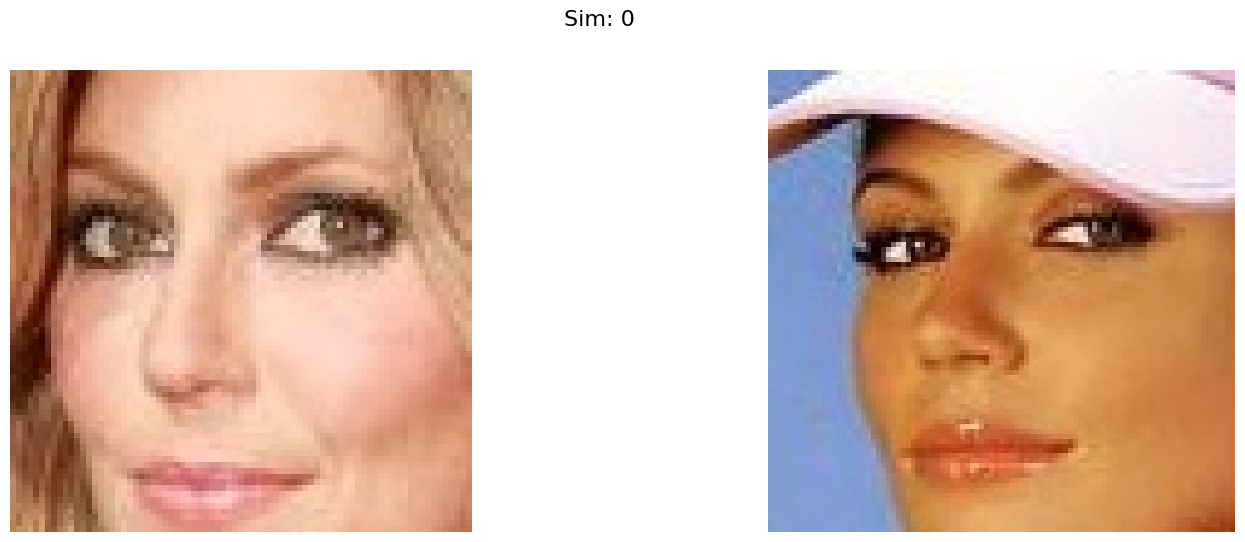

In [ ]:
#misma clase
visualize_pair(pairsTrain.loc[0])

Ejemplo para distinta identidad.

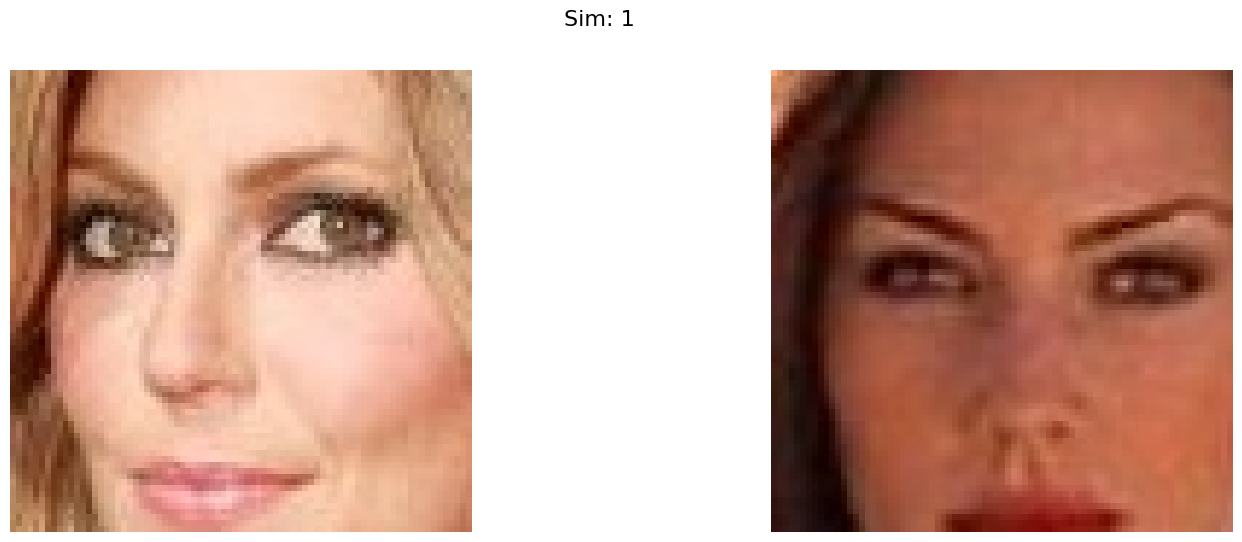

In [ ]:
visualize_pair(pairsTrain.loc[1])

<a id="4"></a>
## 4. Arquitectura de la red neuronal

En este codigo siguiente, se procederá a diseñar la arquitectura de la red neuronal.

Se define una funcion llamada DataGenerator, que se utiliza para cargar lotes de datos desde un DataFrame, donde cada fila contiene la información sobre dos imágenes y su similitud.

In [ ]:
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]

    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y

Carga de lotes de datos de entrenamiento, validación y prueba respectivamente.

In [ ]:
trainGenerator = DataGenerator(pairsTrain, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
valGenerator = DataGenerator(pairsVal, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
testGenerator = DataGenerator(pairsTest, batch_size=1, img_size=img_size, img_dir=img_dir, shuffle=False)

Definicion de la funcion euclidiana con tal de calcular la distancia entre dos tensores. Para valores proximos a 0, significará que son de la misma identidad, en caso de ser proximos a 1, serán imagenes de identidades distintas.

In [ ]:
class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

Carga de modelo prentrenado.

In [ ]:
pretrained_base = hub.KerasLayer(resnset50, trainable = False)

Definicion de la arquitectura de una red neuronal

In [ ]:
input = layers.Input(img_size + (3,))
x = layers.Rescaling(1./255)(input)
x = pretrained_base(x)

x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(512*2, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)

embedding_network = Model(input, x)

input_1 = layers.Input(img_size + (3,))
input_2 = layers.Input(img_size + (3,))

Se completa la definición de una red siamesa que toma pares de imágenes, calcula la distancia euclidiana y genera una predicción de similitud entre las imágenes.

In [ ]:
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

siamese_layer = EuclideanDLayer()
siamese_layer._name = 'distance'

distance = siamese_layer(tower_1, tower_2)

#merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
features = layers.BatchNormalization()(distance)
features = layers.Dense(512, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(128, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(32, activation="relu")(features)
output_layer = layers.Dense(1, activation="sigmoid")(features)

Toma un par de imágenes como entrada y produce una salida que representa la predicción de similitud entre esas dos imágenes.

In [ ]:
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)

La función de pérdida devuelve la media de la pérdida calculada. Esta función de pérdida se utiliza para aprender a comparar pares de ejemplos y minimizar la pérdida entre ejemplos similares y maximizarla entre ejemplos disimilares.

In [ ]:
def loss(margin=1.0):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

Una vez que se ha compilado el modelo siamés con estos ajustes, está listo para ser entrenado utilizando datos de entrenamiento y luego evaluado en datos de validación o prueba.

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])

Resumen de la arquitectura de la red neuronal

In [ ]:
siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 178, 218, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 178, 218, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 128)                  2733492   ['input_5[0][0]',             
                                                          5          'input_6[0][0]']             
                                                                                                  
 distance (EuclideanDLayer)  (None, 1)                    0         ['model_2[0][0]',       

In [ ]:
callbacks = [ModelCheckpoint(f"/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/Weights/{exec_time}_test_8.best",
             save_best_only=True)]

<a id="5"></a>
## 5. Proceso de entrenamiento

En este codigo se inicia el proceso de entrenamiento.

In [ ]:
history = siamese.fit(trainGenerator,
                    validation_data = valGenerator,
                    callbacks=callbacks,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/20
75/75 [==============================] - 670s 9s/step - loss: 0.2277 - accuracy: 0.6275 - val_loss: 0.2140 - val_accuracy: 0.7101
Epoch 2/20
75/75 [==============================] - 36s 481ms/step - loss: 0.2056 - accuracy: 0.6842 - val_loss: 0.1815 - val_accuracy: 0.7326
Epoch 3/20
75/75 [==============================] - 36s 482ms/step - loss: 0.1873 - accuracy: 0.7233 - val_loss: 0.1611 - val_accuracy: 0.7587
Epoch 4/20
75/75 [==============================] - 28s 375ms/step - loss: 0.1799 - accuracy: 0.7356 - val_loss: 0.1690 - val_accuracy: 0.7344
Epoch 5/20
75/75 [==============================] - 38s 505ms/step - loss: 0.1734 - accuracy: 0.7490 - val_loss: 0.1517 - val_accuracy: 0.7622
Epoch 6/20
75/75 [==============================] - 39s 517ms/step - loss: 0.1636 - accuracy: 0.7615 - val_loss: 0.1472 - val_accuracy: 0.7830
Epoch 7/20
75/75 [==============================] - 35s 465ms/step - loss: 0.1562 - accuracy: 0.7783 - val_loss: 0.1471 - val_accuracy: 0.7986
E

Obtención del error en la predicción , y la precisión del modelo.

In [ ]:
siamese.evaluate(testGenerator)

608/608 [==============================] - 77s 124ms/step - loss: 0.1564 - accuracy: 0.7911


[0.15643903613090515, 0.7911184430122375]

Se guarda el modelo de la red siamesa.

In [ ]:
siamese.save(f"/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/models/{exec_time} test_8.model")

Obtencion de la curvas de aprendizaje.

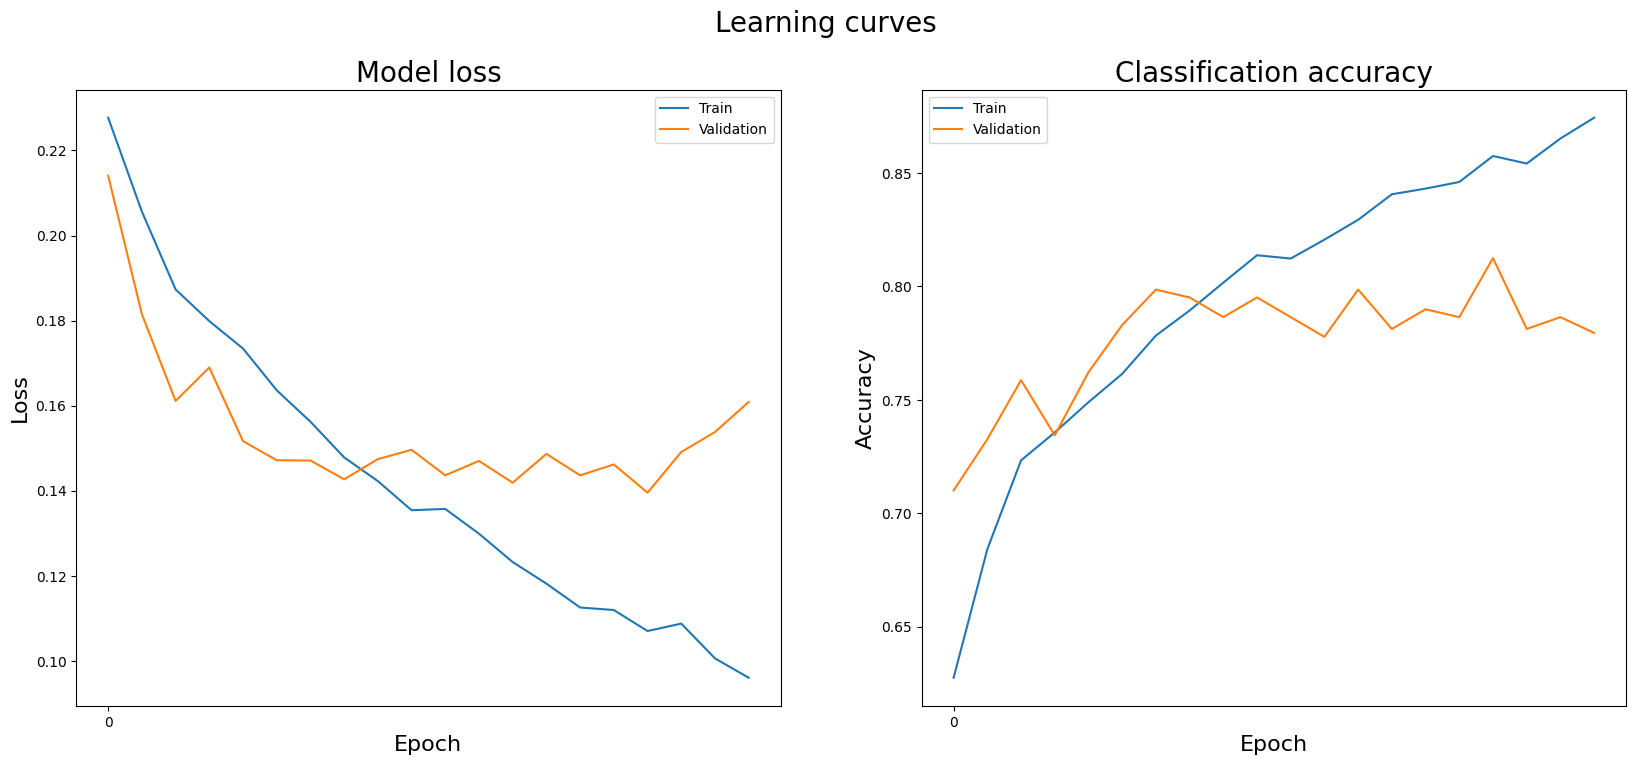

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, 6, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, 6, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()

In [ ]:
pairsTest['Preds'] = siamese.predict(testGenerator)

608/608 [==============================] - 13s 19ms/step


In [ ]:
pairsTest.to_csv(f"/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/models{exec_time} Preds_test_8.txt")

In [ ]:
r2_score(pairsTest['Sim'], pairsTest['Preds'])

0.37424333121488096

In [ ]:
mean_absolute_error(pairsTest['Sim'], pairsTest['Preds'])

0.2376010565012142

<a id="6"></a>
## 6. Visualización de los resultados

In [ ]:
def visualize(pair, to_show=2):
  for i in range(to_show*2):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
      fig.suptitle('Sim: {}\nPred: {}'.format(pair['Sim'].loc[i], pair['Preds'].loc[i]), size=16)
      ax1.imshow(load_img(img_dir + pair['Image1'].loc[i]))
      ax1.set_axis_off()
      ax2.imshow(load_img(img_dir + pair['Image2'].loc[i]))
      ax2.set_axis_off()
  plt.show()

Visualizacion de los resultados.

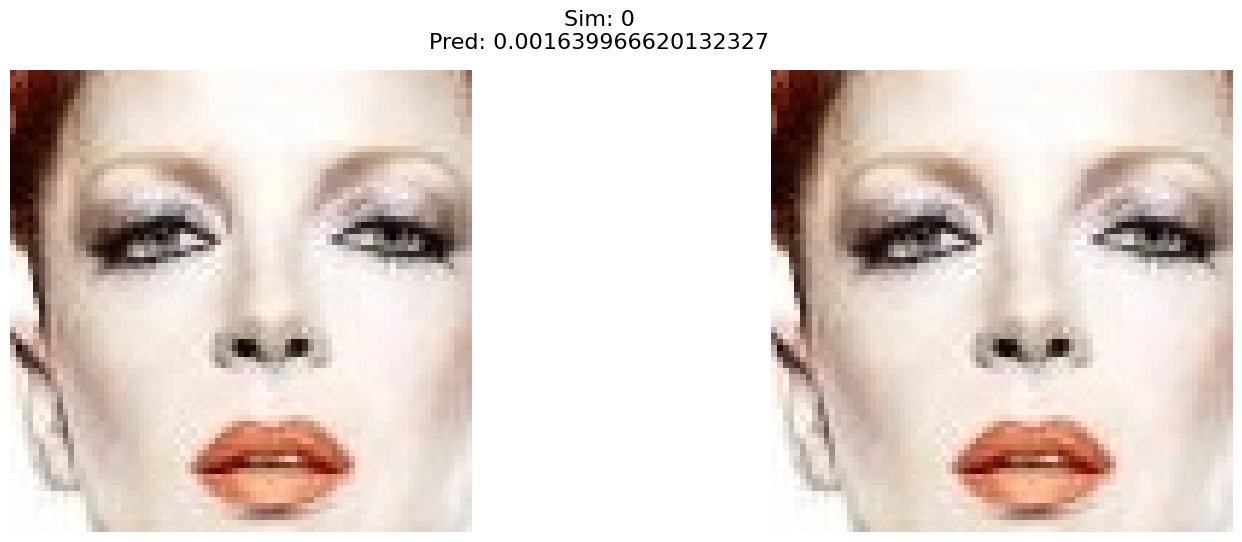

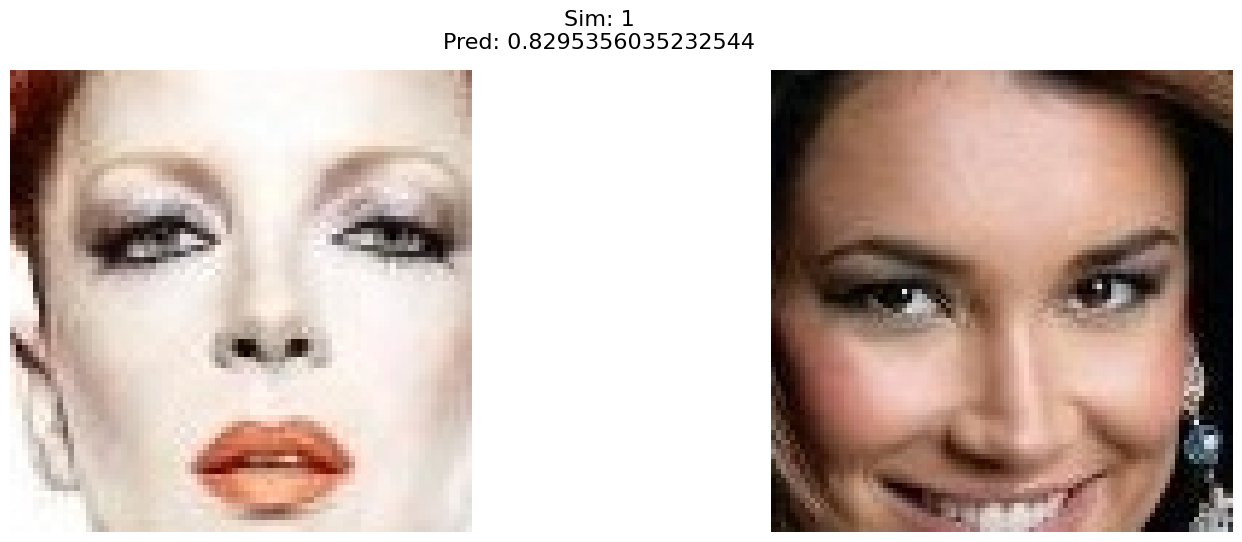

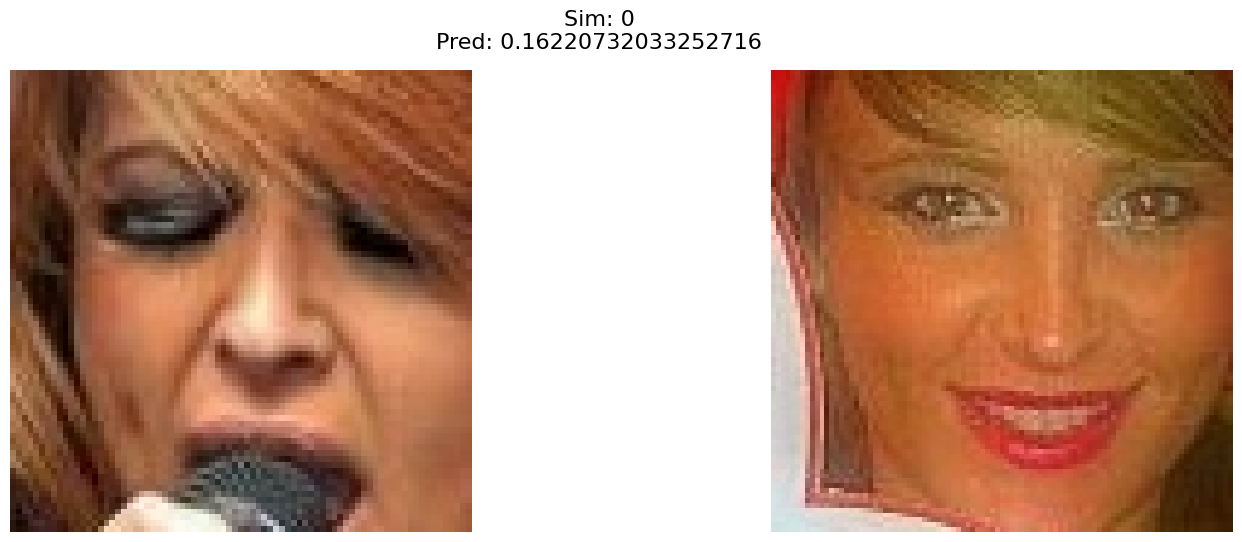

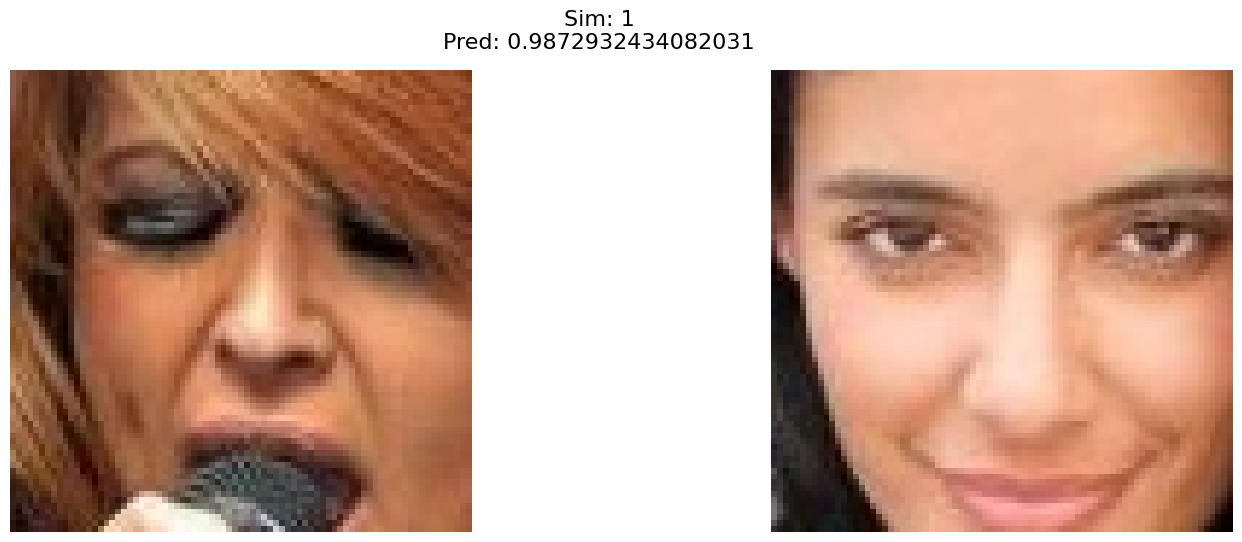

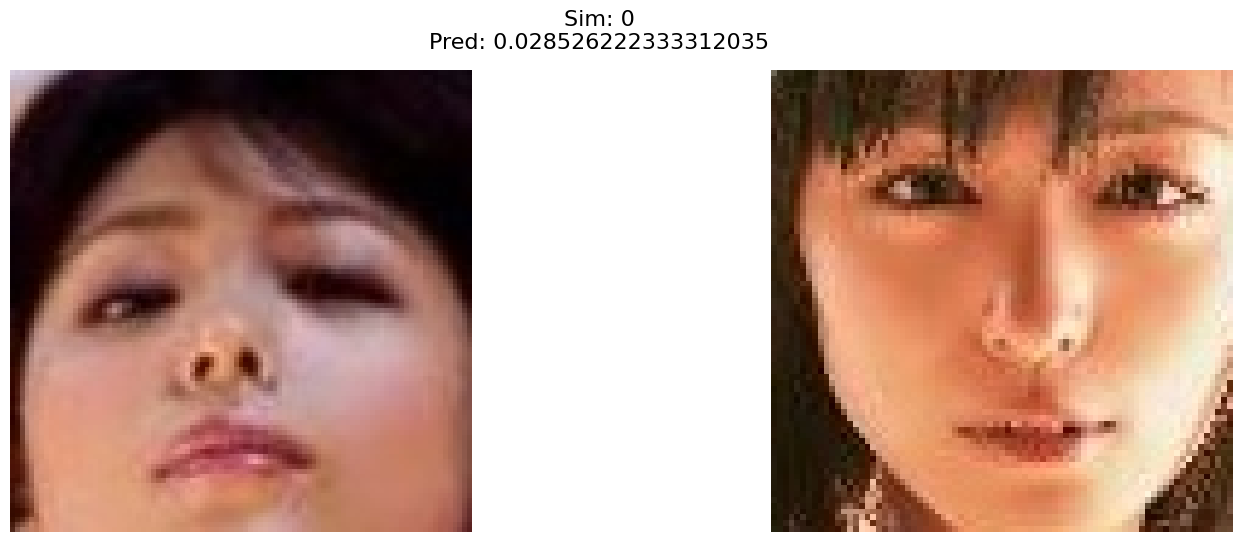

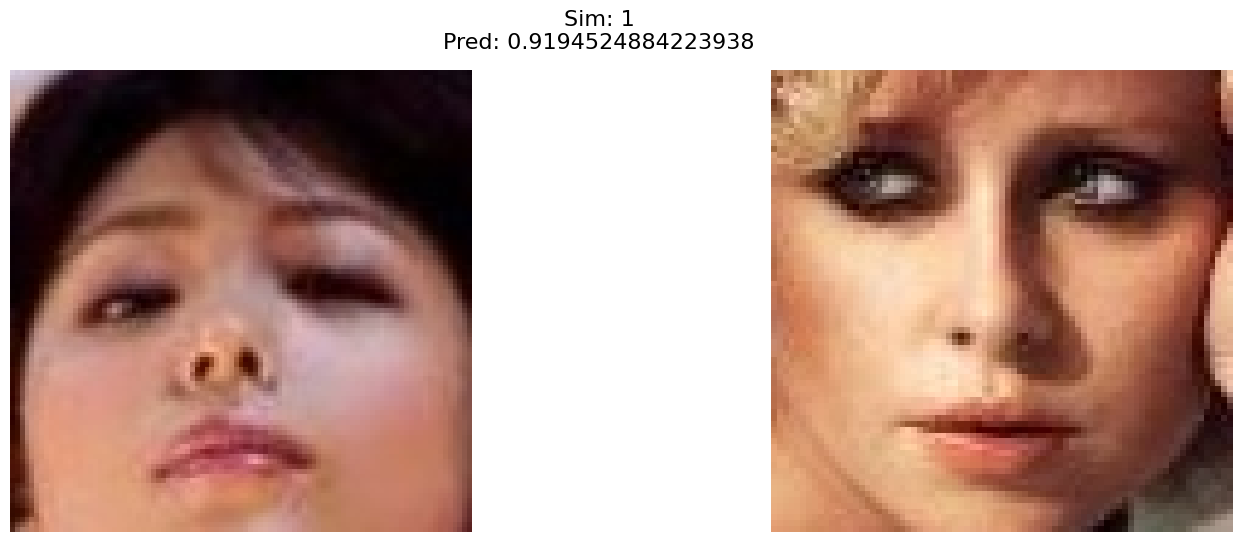

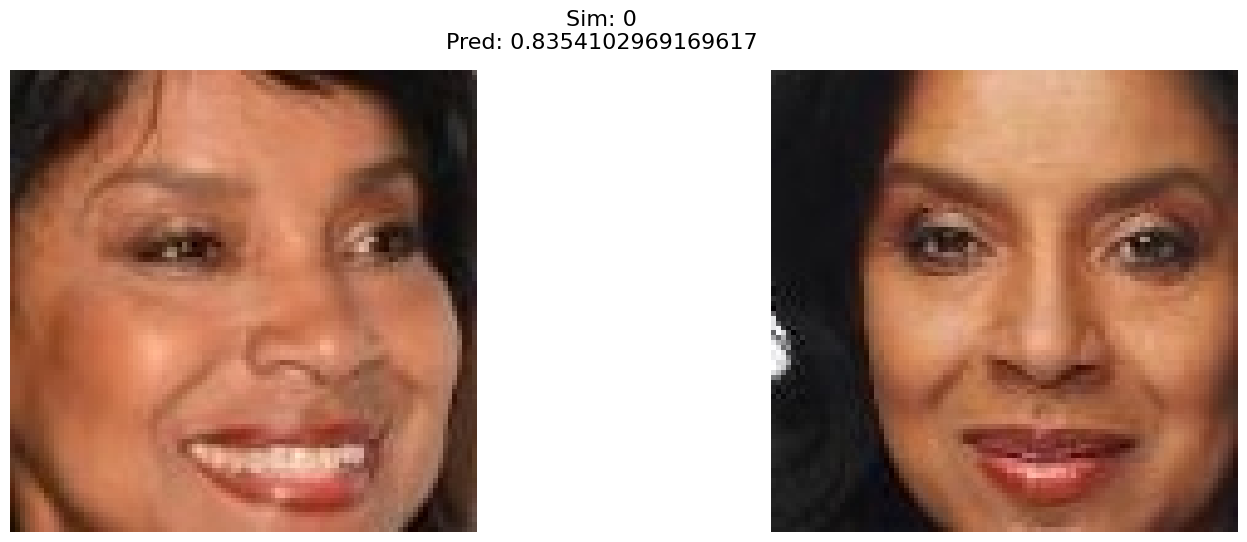

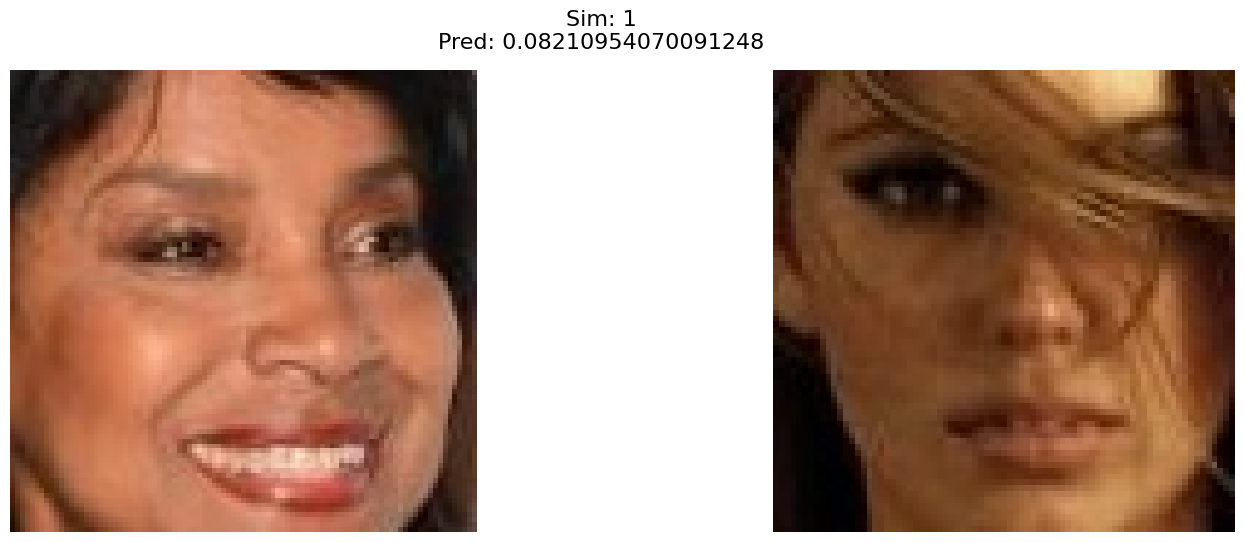

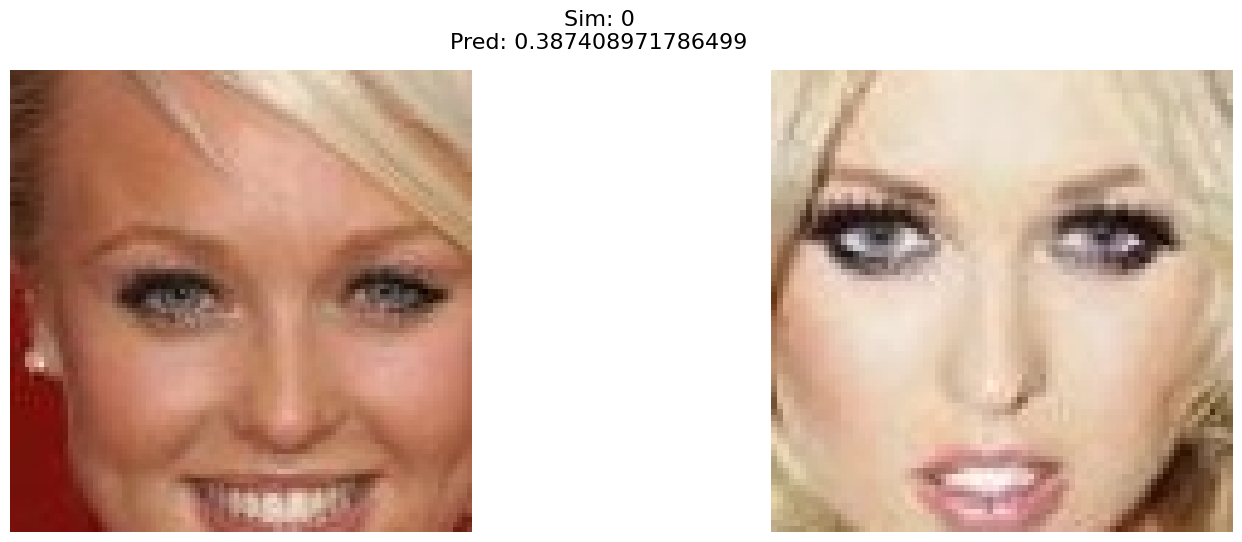

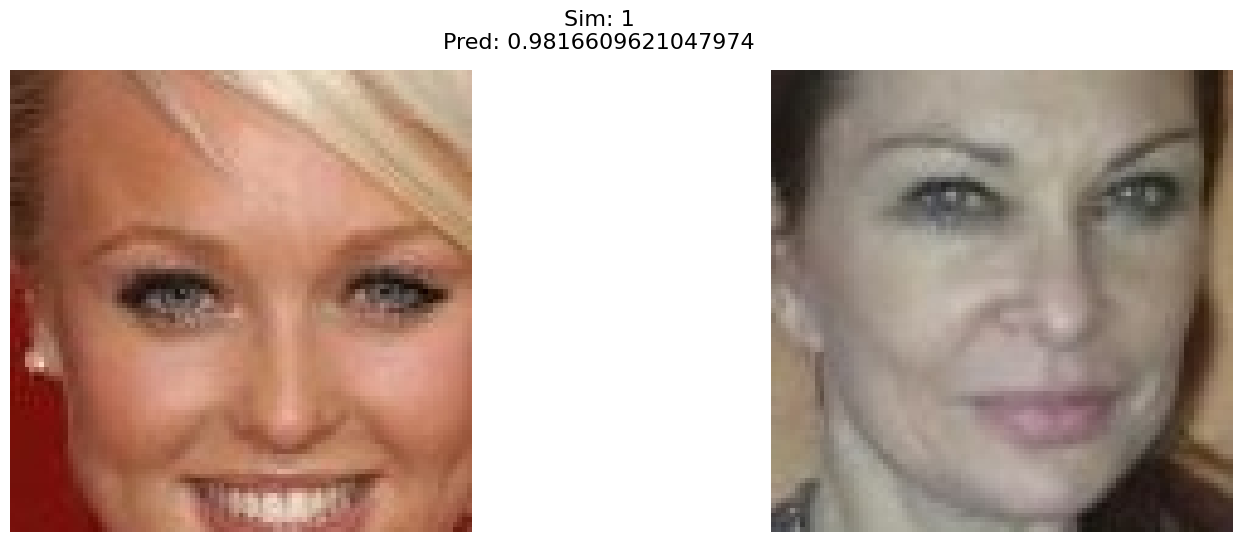

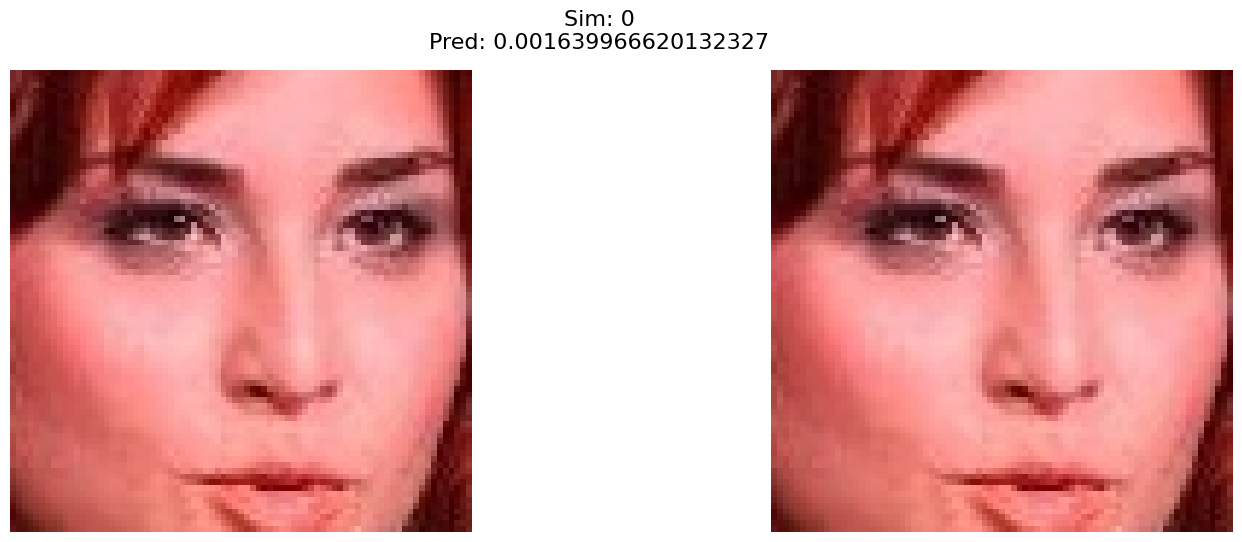

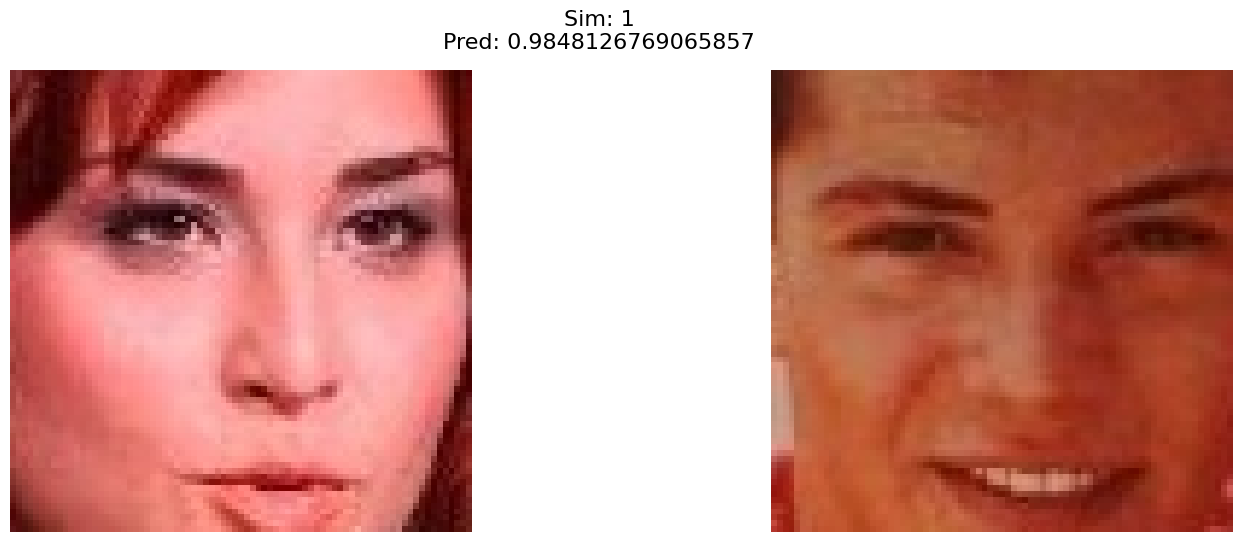

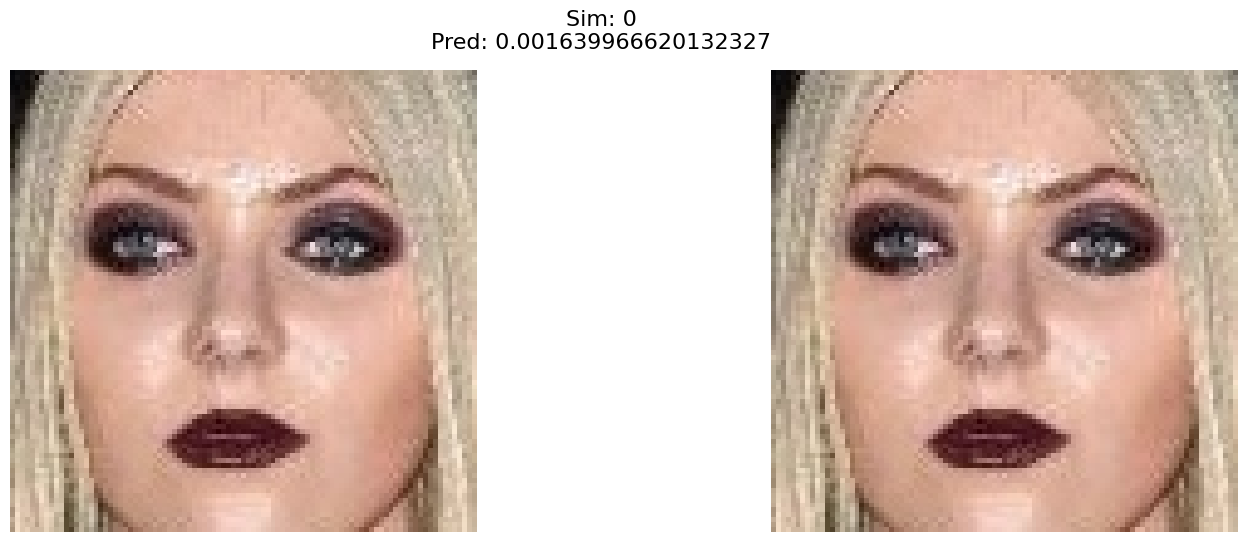

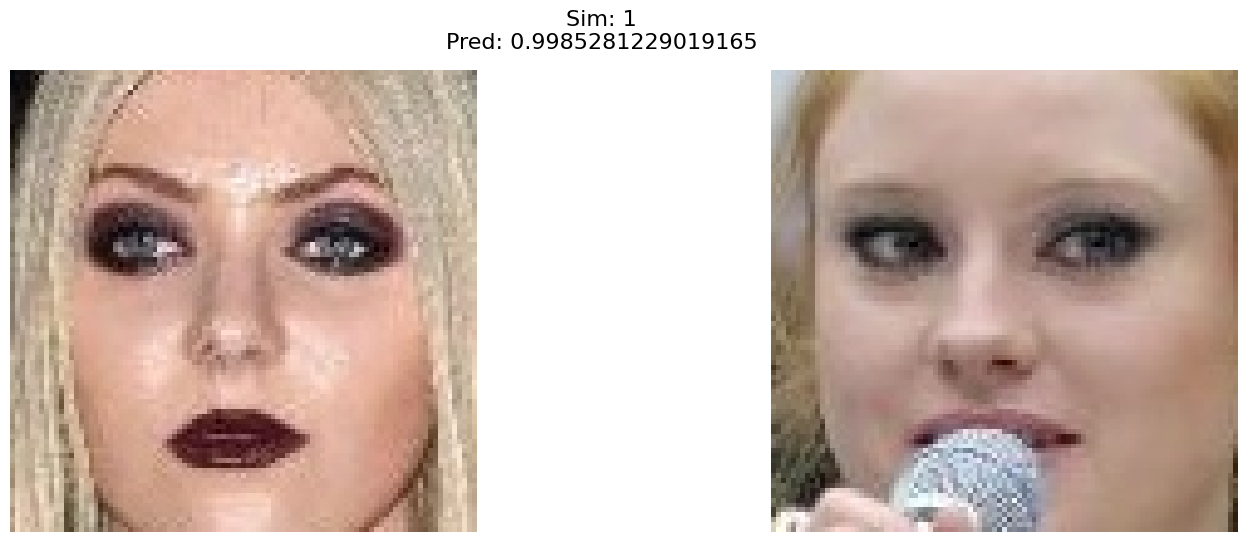

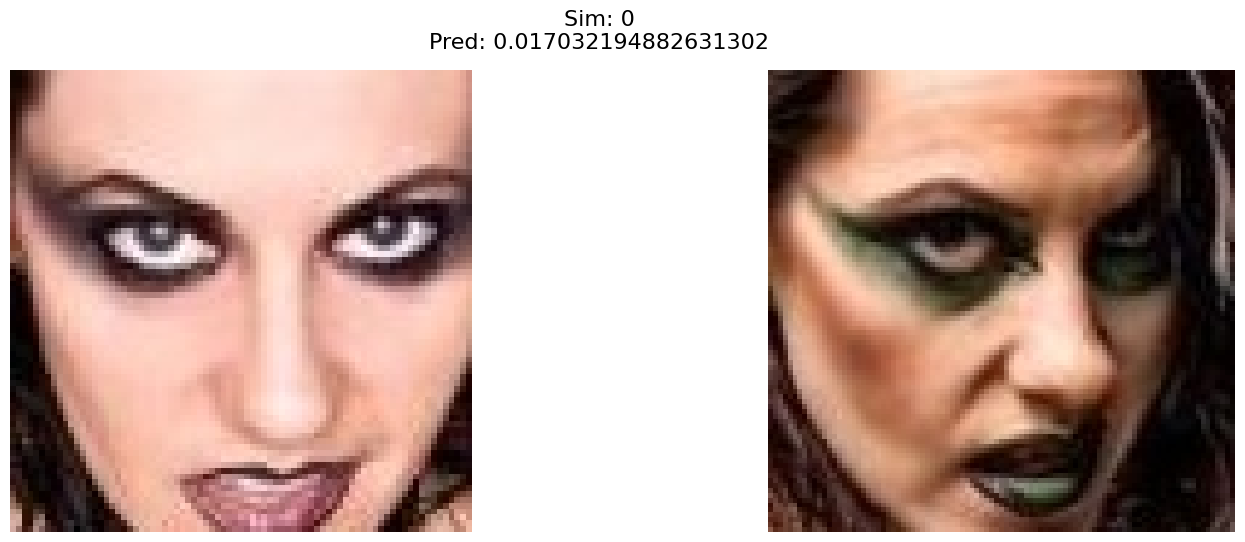

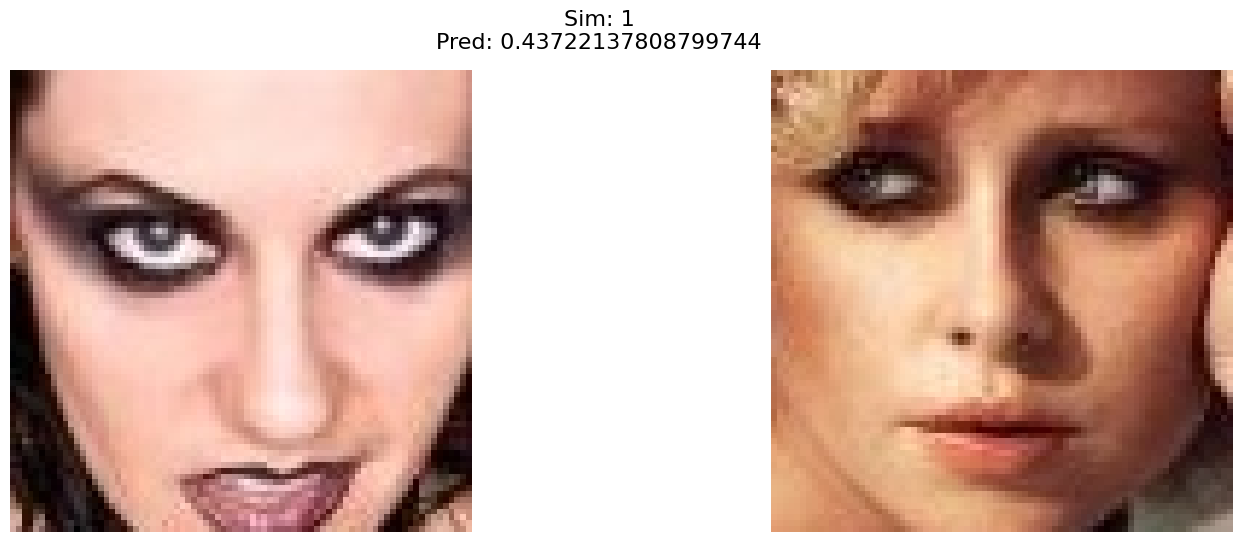

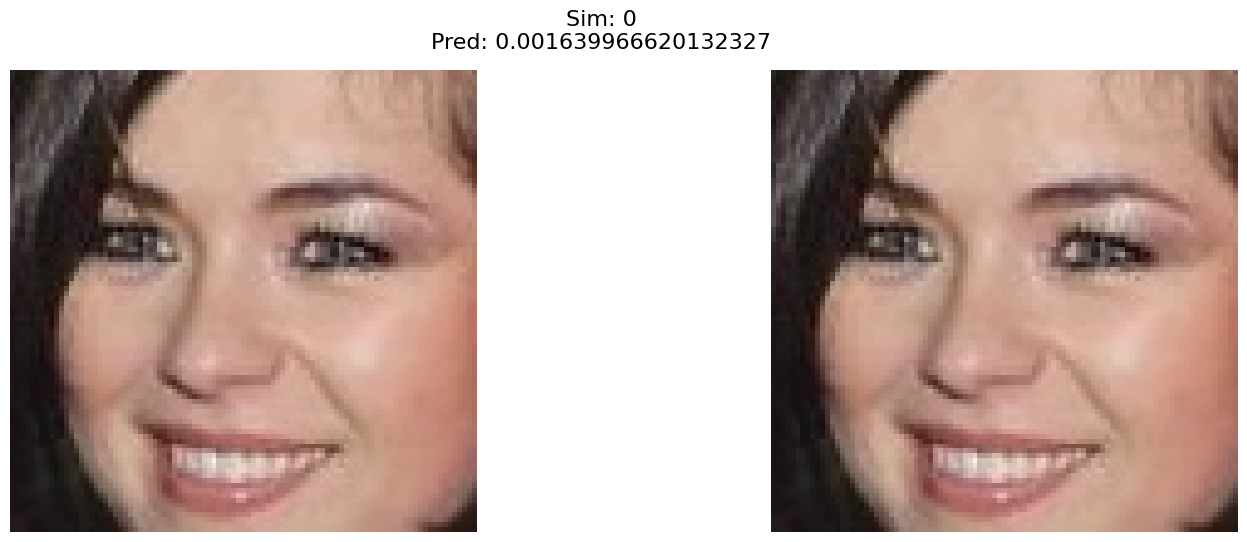

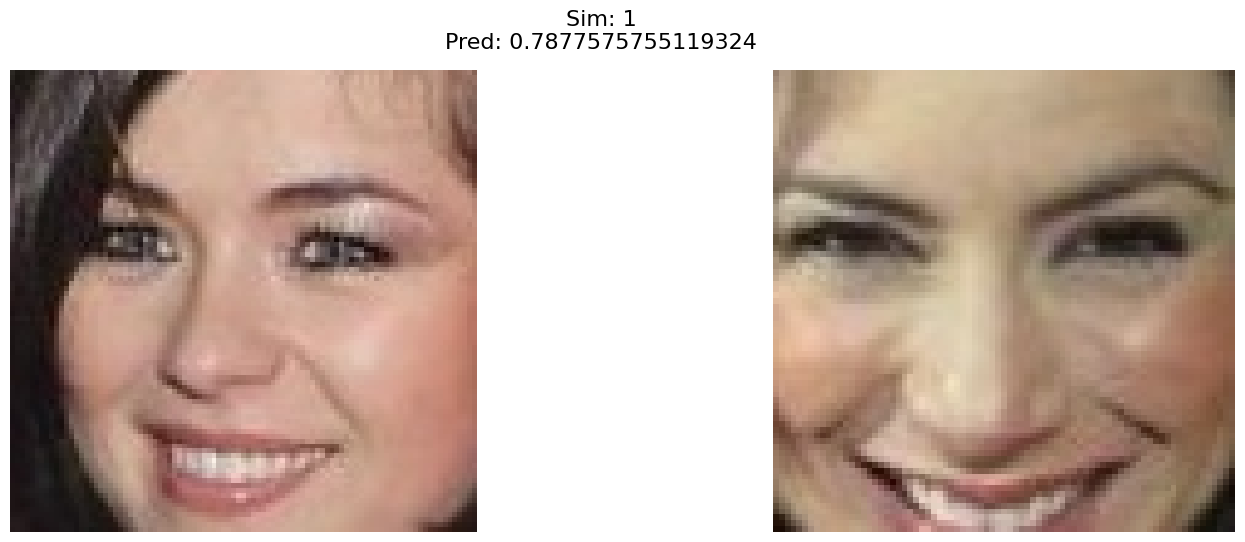

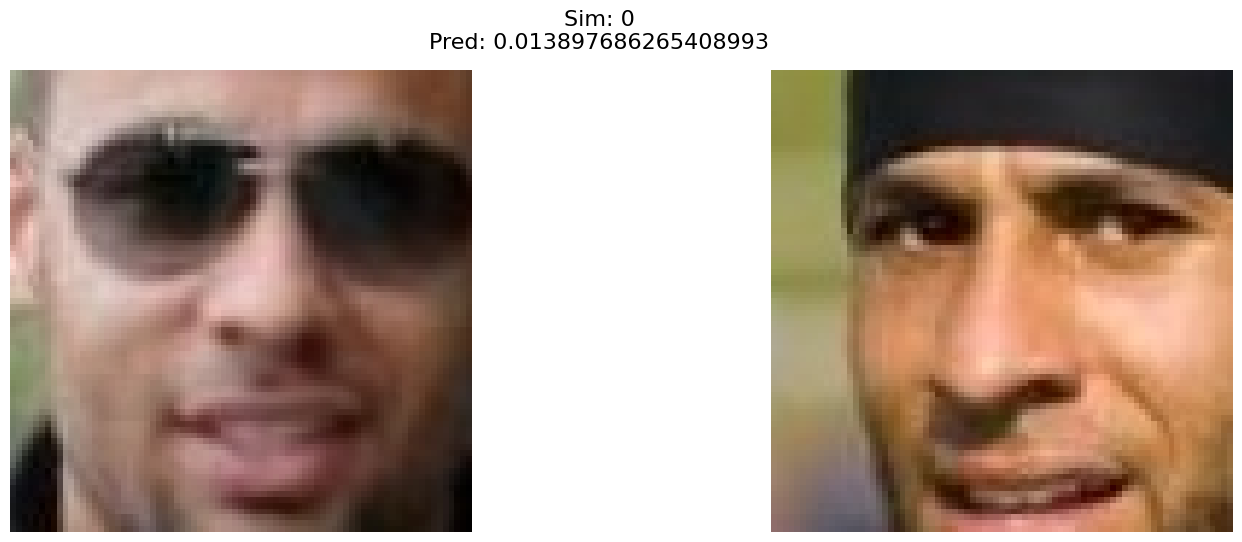

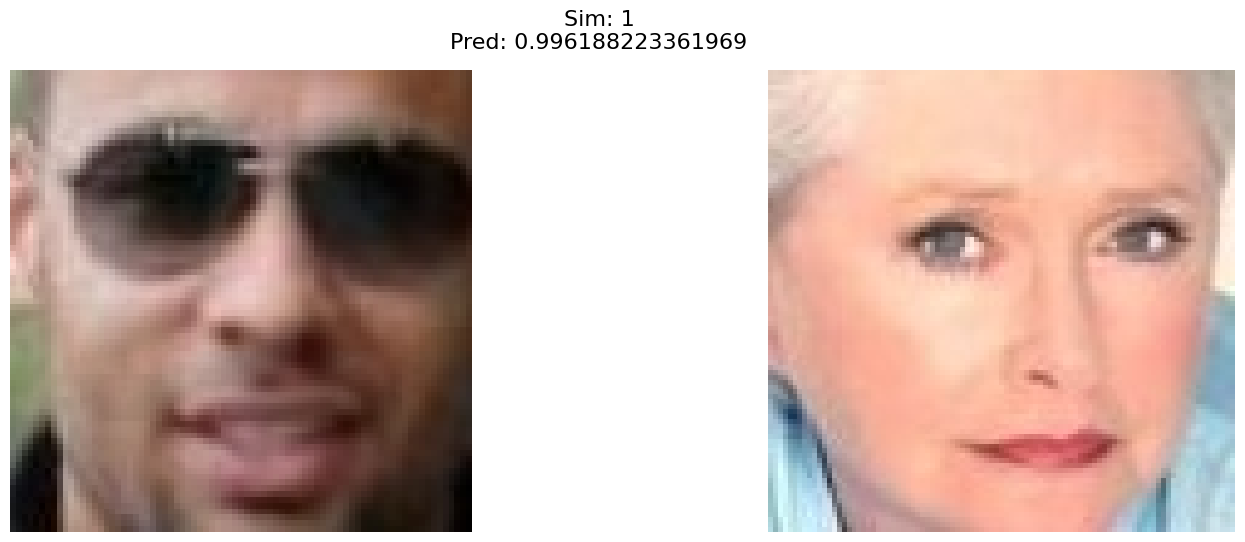

In [ ]:
visualize(pairsTest, to_show=10)

In [ ]:
exec_time

'2023-10-07 10h 33m'